# HCB Method (fixed interface)

This prototype includes: 
- Domain Decomposition (substructuring) 

This prototype excludes: 
- Model order reduction
- Randomness of the system 
- Generalisation for more than two substructures

As illustration, consider a simple longitudinal beam modelled as 5 elements FE model with the following mass and stiffness matrices: 

\begin{equation*}
    \mathbf{M} 
    =
    \frac{1}{5}
    \cdot 
    \begin{bmatrix} 
        1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 2 & 0 & 0 & 0 & 0 \\
        0 & 0 & 2 & 0 & 0 & 0 \\
        0 & 0 & 0 & 2 & 0 & 0 \\
        0 & 0 & 0 & 0 & 2 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1
    \end{bmatrix} 
    \phantom{xx} 
    \text{;} 
    \phantom{xx}
    \mathbf{K} 
    =
    500\cdot 
    \begin{bmatrix} 
        1 & -1 & 0 & 0 & 0 & 0 \\
        -1 & 2 & -1 & 0 & 0 & 0 \\
        0 & -1 & 2 & -1 & 0 & 0 \\
        0 & 0 & -1 & 2 & -1 & 0 \\
        0 & 0 & 0 & -1 & 2 & -1 \\
        0 & 0 & 0 & 0 & -1 & 1
    \end{bmatrix} 
\end{equation*} 

For simplicity, we only consider the following uniform nodal load: 

\begin{equation*}
    \mathbf{f}
    =
    \frac{1}{5}\cdot 
    \begin{bmatrix}
    1 & 1 & 1 & 1 & 1 & 1
    \end{bmatrix}^{T}
\end{equation*}

The model is divided into two substructures: 
- Node $1$, $2$, $3$
- Node $3$, $4$, $5$, $6$ 

Here, node $3$ acts as the boundary node. In addition, a homogenous dirichlet boundary condition is applied to node $6$ i.e. $u_{6}=0$. 

### Preamble

In [47]:
import numpy as np 
from scipy.linalg import sqrtm 
import matplotlib.pyplot as plt 

omega = 30.0

## Compute Matrices of Each Substructure

Matrices and vectors of each substructure are computed independently and in parallel 

### Substructure 1 

The following computations are performed independently on computer 1

In [48]:
# Assemble mass & stiffness matrices and load vector 

M_1 = 0.2 * np.array([[ 1, 0, 0],
                      [ 0, 2, 0],
                      [ 0, 0, 1]]) 

K_1 = 500 * np.array([[ 1,-1, 0],
                      [-1, 2,-1],
                      [ 0,-1, 1]])

f_1 = 0.2 * np.array([[1],
                      [1],
                      [1]])

# Compute internal mode with boundary node (node 3) fixed 

M_II_1 = M_1[0:2,0:2]
K_II_1 = K_1[0:2,0:2]

_, Phi_N_1 = np.linalg.eig( np.linalg.solve( M_II_1, K_II_1 ) )

# Use mass - normalised eigenmodes 

Phi_N_1 = np.linalg.solve( 
    sqrtm( (np.transpose(Phi_N_1) @ M_II_1 @ Phi_N_1)  ), Phi_N_1 
) 

# Compute boundary mode

K_IB_1 = K_1[0:2,2]

Phi_C_1 = - np.reshape( np.linalg.solve( K_II_1, K_IB_1 ), (2,1) )

# Compute transformation matrix 

I = np.eye( Phi_C_1.shape[1] )
O = np.zeros( (I.shape[0], Phi_N_1.shape[1]) )

G_1 = np.vstack(( np.hstack( (Phi_N_1, Phi_C_1) ),
                  np.hstack( (      O,       I) )))

# Compute modal system of equations 

D_1 = np.transpose(G_1) @ ( K_1 - omega * omega * M_1 ) @ G_1

# Compute Schur complement matrix 

D_NN_1 = D_1[0:2,0:2] 
D_NC_1 = D_1[0:2,2] 
D_CN_1 = D_1[2,0:2] 
D_CC_1 = D_1[2,2]

S_1 =  D_CC_1 - D_CN_1 @ np.linalg.solve( D_NN_1, D_NC_1 ) 

# Compute load vector 

F_1 = np.transpose(G_1) @ f_1

F_N_1 = F_1[0:2,0] 
F_C_1 = F_1[2,0] 

P_1 = F_C_1 - D_CN_1 @ np.linalg.solve( D_NN_1, F_N_1 ) 

# Send S_1 and P_1 to central computer to calculate u_C i.e. u_3

### Substructure 2

The following computations are performed independently on computer 2

In [49]:
# Assemble mass & stiffness matrices and load vector 

M_2 = np.array([[ 0.4, 0.0, 0.0, 0.0],
                [ 0.0, 0.4, 0.0, 0.0],
                [ 0.0, 0.0, 1.0, 0.0],
                [ 0.0, 0.0, 0.0, 0.2]]) 

K_2 = np.array([[1000,-500, 0,-500],
                [-500,1000, 0,   0],
                [   0,   0, 1,   0],
                [-500,   0, 0, 500]])

f_2 = np.array([[0.2],
                [0.2],
                [0.0],
                [0.0]])

# Compute internal mode with boundary node and clamped node (node 3 and 6) fixed 

M_II_2 = M_2[0:3,0:3]
K_II_2 = K_2[0:3,0:3]


_, Phi_N_2 = np.linalg.eig( np.linalg.solve( M_II_2, K_II_2 ) )

# Use mass - normalised eigenmodes 

Phi_N_2 = np.linalg.solve( 
    sqrtm( (np.transpose(Phi_N_2) @ M_II_2 @ Phi_N_2) ), Phi_N_2 
) 

# Compute boundary mode

K_IB_2 = K_2[0:3,3]

Phi_C_2 = - np.reshape( np.linalg.solve( K_II_2, K_IB_2 ), (3,1) )

# Compute transformation matrix 

I = np.eye( Phi_C_2.shape[1] )
O = np.zeros( (I.shape[0], Phi_N_2.shape[1]) )

G_2 = np.vstack(( np.hstack( (Phi_N_2, Phi_C_2) ),
                  np.hstack( (      O,       I) )))

# Compute modal system of equations 

D_2 = np.transpose(G_2) @ ( K_2 - omega * omega * M_2 ) @ G_2

# Compute Schur complement matrix 

D_NN_2 = D_2[0:3,0:3] 
D_NC_2 = D_2[0:3,3] 
D_CN_2 = D_2[3,0:3] 
D_CC_2 = D_2[3,3]

S_2 =  D_CC_2 - D_CN_2 @ np.linalg.solve( D_NN_2, D_NC_2 ) 

# compute load vector 

F_2 = np.transpose(G_2) @ f_2

F_N_2 = F_2[0:3,0] 
F_C_2 = F_2[3,0] 

P_2 = F_C_2 - D_CN_2 @ np.linalg.solve( D_NN_2, F_N_2 ) 

# Send S_2 and P_2 to central computer to calculate u_C i.e. u_3

## Solve Boundary DoF(s) 

Matrices and vectors from each substructure are gathered in one central computer and boundary DoF's value is calculated

In [50]:
# Receive S_1 & P_1 from computer 1
# Receive S_2 & P_2 from computer 2

u_C = (P_1+P_2) / (S_1+S_2)  

# Send / broadcast u_C to computer 1 and 2

## Solve Internal DoFs 

Boundary DoF's value is broadcasted to all computers and internal DoFs of each substructure are calculated independently and in parallel 

### Solve for internal mode 1

The following computations are performed independently on computer 1

In [51]:
# Receive u_C from central computer 

u_N_1 = np.linalg.solve( D_NN_1, (F_N_1 - u_C * D_NC_1) )

# Transform from modal space to physical space 

u_1 = np.reshape( Phi_N_1 @ u_N_1, (2,1) ) + np.reshape( u_C * Phi_C_1, (2,1) )

# Send u_1 to central computer for postprocessing (only if needed)

### Solve for internal mode 2

The following computations are performed independently on computer 2

In [52]:
# Receive u_C from central computer 

u_N_2 = np.linalg.solve( D_NN_2, (F_N_2 - u_C * D_NC_2) )

# Transform from modal space to physical space 

u_2 = np.reshape( Phi_N_2 @ u_N_2, (3,1) ) + np.reshape( u_C * Phi_C_2, (3,1) )

# Send u_2 to central computer for postprocessing (only if needed)

## Postprocessing 

This step is just to compare results obtained from the method with results from solving the full system of equations 

### Gather Solutions

The following computations are only performed on central computer if all DoF values are needed for postprocessing

In [53]:
# Receive u_1 from computer 1 (only if needed) 
# Receive u_2 from computer 2 (only if needed) 

u_HCB = np.vstack((np.vstack ((u_1,u_C)),u_2))

### Compare with Full Solution

The following computations are just peformed to compare the results of solving the full system of equations with the results from HCB method 

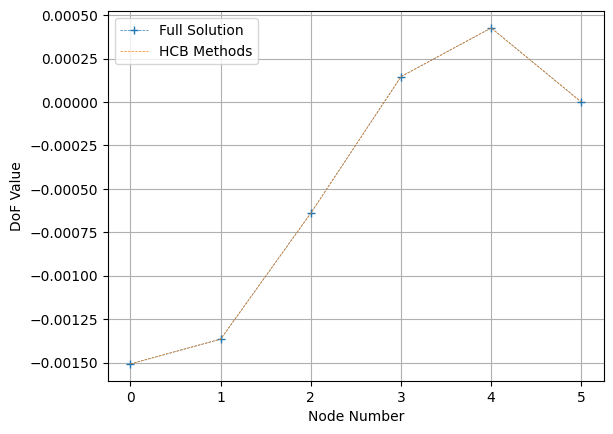

In [56]:
# Assemble full mass & stiffness matrices and load vector 

M = 0.2 * np.array([[ 1, 0, 0, 0, 0, 0],
                    [ 0, 2, 0, 0, 0, 0],
                    [ 0, 0, 2, 0, 0, 0],
                    [ 0, 0, 0, 2, 0, 0],
                    [ 0, 0, 0, 0, 2, 0],
                    [ 0, 0, 0, 0, 0, 1]])

K = 500 * np.array([[ 1,-1, 0, 0, 0, 0],
                    [-1, 2,-1, 0, 0, 0],
                    [ 0,-1, 2,-1, 0, 0],
                    [ 0, 0,-1, 2,-1, 0],
                    [ 0, 0, 0,-1, 2, 0],
                    [ 0, 0, 0, 0, 0, 1]])

F = 0.2 * np.array([[1],
                    [1],
                    [1],
                    [1],
                    [1],
                    [0]])

# Solve full system of equations 

u_F = np.linalg.solve( (K - omega * omega * M), F)

# Postprocessing 

indices = np.arange( len(u_F) ) 

plt.plot( 
    indices, u_F, 
    linestyle = '--', 
    linewidth = 0.5, 
    marker = '+', 
    label = "Full Solution" 
) 

plt.plot( 
    indices, u_HCB, 
    linestyle = '--', 
    linewidth = 0.5, 
    marker = '', 
    label = "HCB Methods" 
) 

plt.xlabel('Node Number') 
plt.ylabel('DoF Value') 

plt.grid( True ) 
plt.legend() 
plt.show()